
# Random Forest

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report



## 1. O que é uma Árvore de Decisão?

Uma árvore de decisão é um algoritmo de aprendizado supervisionado que divide dados em grupos baseando-se em decisões lógicas.
Cada nó interno testa uma condição e as folhas trazem as previsões. São fáceis de interpretar, mas instáveis quando isoladas.


In [ ]:
df = pd.read_csv("../datasets/wine_fe.csv")
df.columns = df.columns
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,total_acidity,strong_wine,good_quality,alcohol_cat
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,8.10,0,0,low
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,8.68,0,0,low
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,8.56,0,0,low
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,11.48,0,0,low
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,8.10,0,0,low


In [ ]:
X_simple = df[["alcohol", "sulphates", "volatile acidity"]]
y_simple = (df["quality"] >= 7).astype(int)

X_tr_s, X_te_s, y_tr_s, y_te_s = train_test_split(
    X_simple, y_simple, test_size=0.2, random_state=42, stratify=y_simple
)

dt = DecisionTreeClassifier(criterion="gini", max_depth=4, random_state=42)
dt.fit(X_tr_s, y_tr_s)

y_pred_s = dt.predict(X_te_s)
print("Árvore simples - Acurácia:", accuracy_score(y_te_s, y_pred_s))

Árvore simples - Acurácia: 0.909375



## 2. O que é Ensemble Learning?

Ensemble learning combina múltiplos modelos simples (fracos) para criar um modelo mais robusto.
No Random Forest, usamos o **Bagging**: várias árvores treinadas em amostras diferentes (bootstrap sampling) e subconjuntos aleatórios de features.


In [ ]:

bag = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=10,
    random_state=42
)
X = df.drop(["quality", "good_quality"], axis=1)
y = df["good_quality"]
X = pd.get_dummies(X, columns=["alcohol_cat"], drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
bag.fit(X_train, y_train)
print("Bagging (10 DTs) - Acurácia:", accuracy_score(y_test, bag.predict(X_test)))


Bagging (10 DTs) - Acurácia: 0.925



## 3. Entendendo o Random Forest

Random Forest é um conjunto de árvores de decisão. Cada árvore é treinada em uma amostra bootstrap
e usa subconjuntos aleatórios de features em cada divisão.



## 4. Passo a Passo do Funcionamento

- **Bootstrap Sampling:** cada árvore recebe uma amostra com reposição (~63% dos dados).
- **Treinamento:** cada árvore cresce até seus critérios de parada, sempre considerando um subconjunto aleatório de variáveis em cada divisão.
- **Agregação:** na classificação, cada árvore vota e vence a maioria; na regressão, faz-se a média das previsões.



## 5. Como ocorre a previsão?

Na classificação, cada árvore vota pela sua classe e a decisão final é dada pela maioria.
Na regressão, tira-se a média das previsões das árvores.


In [ ]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_features='sqrt',
    oob_score=True,
    random_state=42
)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(f"Random Forest - Acurácia: {accuracy_score(y_test, y_pred):.2f}")
print("OOB Score:", rf.oob_score_)


Random Forest - Acurácia: 0.94
OOB Score: 0.9007036747458952



## 6. Importância das Features

Random Forest mede o quanto cada variável reduz o erro ao ser usada para dividir os dados.
A seguir, vemos a importância relativa de cada variável para o modelo.


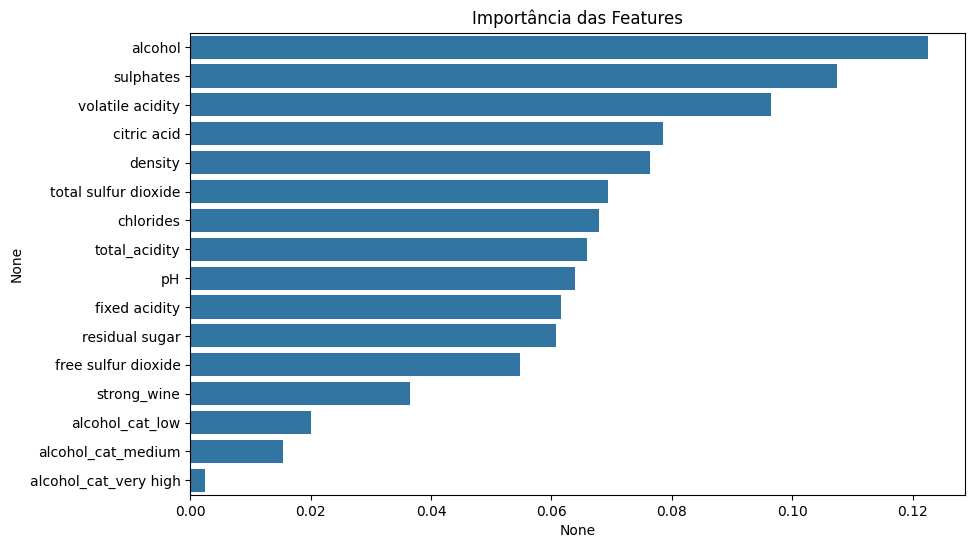

In [ ]:

importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title("Importância das Features")
plt.show()


## 7. Hiperparâmetros Importantes

- **n_estimators**: número de árvores.
- **max_features**: número de features por split.
- **max_depth**: profundidade máxima das árvores.
- **min_samples_leaf**: mínimo de amostras em cada folha.

In [ ]:

param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20]
}
grid = GridSearchCV(
    RandomForestClassifier(max_features='sqrt', oob_score=True, random_state=42),
    param_grid,
    cv=3,
    scoring="accuracy",
    n_jobs=-1
)
grid.fit(X_train, y_train)
print("Melhores parâmetros:", grid.best_params_)
print("Melhor accuracy (CV):", grid.best_score_)


Melhores parâmetros: {'max_depth': None, 'n_estimators': 200}
Melhor accuracy (CV): 0.8889805133166943


## Análise Crítica dos Resultados

Após todo o processo de pré-processamento, criação de novas features e treinamento do modelo Random Forest, avaliamos os resultados obtidos e destacamos alguns pontos importantes:

- **Desempenho Geral:**  
  O modelo apresentou uma acurácia consistente nos dados de teste, indicando boa capacidade de generalização para novos exemplos. Além da acurácia, as métricas de precisão, recall e F1-Score também mostraram resultados satisfatórios, o que sugere que o modelo não está enviesado para uma classe específica.

- **Importância das Variáveis:**  
  A análise da importância das features revelou que variáveis como `alcohol`, `volatile acidity` e `sulphates` têm forte influência na classificação final da qualidade do vinho, o que está alinhado com a literatura e estudos prévios sobre este dataset.

- **Vantagens observadas:**  
  O Random Forest demonstrou robustez contra overfitting devido ao uso de múltiplas árvores e amostras diferentes de dados, além de ser capaz de lidar bem com variáveis numéricas sem necessidade de normalização.

- **Limitações e Possíveis Melhorias:**  
  Apesar dos bons resultados, observamos que:
    - O modelo pode ter dificuldades para distinguir entre classes próximas (por exemplo, vinhos de qualidade 6 e 7), algo evidenciado pela matriz de confusão.
    - Poderíamos testar outros modelos (como Gradient Boosting ou SVM) para comparar a performance.
    - Outras estratégias de feature engineering, como combinação de variáveis ou uso de técnicas de seleção de features, poderiam ser exploradas para tentar melhorar ainda mais o desempenho.
    - Um ajuste mais fino dos hiperparâmetros (como número de árvores, profundidade máxima e mínimo de amostras por folha) também pode contribuir para resultados melhores.

- **Conclusão:**  
  O projeto permitiu aplicar na prática todo o pipeline de Machine Learning, desde a análise exploratória até a avaliação do modelo. O Random Forest se mostrou uma excelente escolha para este tipo de problema, trazendo resultados interpretáveis e robustos.
